# Generate (message, image) recommendations for each user

In [1]:
import os
import openai
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

openai.api_key = os.environ['OPENAI_API_KEY']
np.set_printoptions(precision=3, suppress=True)
sns.set_theme(style='ticks', palette='Set2', font='monospace', font_scale=1.)


def get_embedding(text):
    """Compute embedding for a given text string."""
    result = openai.Embedding.create(input=text, model='text-embedding-ada-002')
    return np.array(result.data[0].embedding)


def center_embeddings(df):
    """Offset embeddings by it's center."""
    emb_center = df['embedding'].mean()
    df['embedding'] = df['embedding'].apply(lambda emb: emb - emb_center)


def softmax(x, temp=1.):
    """Compute row-wise softmax of a matrix x."""
    z = np.array(x)
    z -= z.max(axis=1, keepdims=True)
    z = np.exp(z / temp)
    z /= z.sum(axis=1, keepdims=True)
    return z


def visualize_embeddings():
    """Plot PCA projection of embeddings."""
    # compute embedding pca
    embs = np.array(messages.embedding.tolist() + images.embedding.tolist() + users.embedding.tolist())
    emb_pca = PCA(n_components=2).fit_transform(embs)
    messages_pca, images_pca, users_pca = np.split(emb_pca, [len(messages),-len(users)])

    # plot pca for messages, images, users
    fig, ax = plt.subplots(figsize=(6,4))
    ax.scatter(messages_pca[:,0], messages_pca[:,1], s=100)
    ax.scatter(images_pca[:,0], images_pca[:,1], s=100)
    ax.scatter(users_pca[:,0], users_pca[:,1], s=100)

    # add legend
    ax.scatter(-1, -1, s=125, color=sns.color_palette()[0], label='messages')
    ax.scatter(-1, -1, s=125, color=sns.color_palette()[1], label='images')
    ax.scatter(-1, -1, s=125, color=sns.color_palette()[2], label='users')
    ax.legend()
    
    # configure axes
    (x0, y0), (x1, y1) = 1.25*emb_pca.min(axis=0), 1.25*emb_pca.max(axis=0)
    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)    
    plt.tight_layout()
    plt.show()


def get_embedding_user(user, wl=.2, wd=.2):
    """Compute user embeddings accounting for likes and dislikes."""
    demo = f'{user.Age} year old {user.Race.lower()} {user.Gender.lower()}'
    emb = get_embedding(demo)

    # positively adjust embedding for likes
    for like in user.Likes.split(';'):
        emb += wl * get_embedding(like)
    
    # negatively adjust embedding for dislikes
    for dislike in user.Dislikes.split(';'):
        emb -= wd * get_embedding(dislike)
    
    return emb


def get_prefs(pref='norm', temp=.1, k=5):
    """Compute (user,message,image) proximity and return top k recommendations."""
    num_messages = len(messages)
    num_images = len(images)

    # compute preferences
    user_prefs = []
    for u, user_emb in enumerate(users.embedding[:5]):
        prefs = np.zeros((num_messages, num_images))
        for i, message_emb in enumerate(messages.embedding):
            for j, image_emb in enumerate(images.embedding):

                if pref == 'norm':
                    prefs[i][j] = -np.linalg.norm(user_emb - message_emb)\
                                - np.linalg.norm(user_emb - image_emb)\
                                - np.linalg.norm(message_emb - image_emb)
                elif pref == 'cos':
                    prefs[i][j] = cossim(user_emb, message_emb)\
                                + cossim(user_emb, image_emb)\
                                + cossim(message_emb, image_emb)
                elif pref == 'dot':
                    prefs[i][j] = np.dot(user_emb, message_emb)\
                                + np.dot(user_emb, image_emb)\
                                + np.dot(message_emb, image_emb)
                elif pref == 'ans':
                    prefs[i][j] = anssim(user_emb, message_emb)\
                                + anssim(user_emb, image_emb)\
                                + anssim(message_emb, image_emb)

        # normalize preferences
        probs = softmax(prefs.reshape(1,-1), temp=temp).reshape(num_messages, num_images)
        user_prefs.append(probs)

        # show k best recommendations for each person
        user = users.iloc[u]
        print(f'User {u}')
        print(f"Demographics: {user.Age} year old {user.Race.lower()} {user.Gender.lower()}")
        print(f"Likes: {', '.join(user.Likes.split(';'))}")
        print(f"Dislikes: {', '.join(user.Dislikes.split(';'))}\n")
        for ii, jj in zip(*np.unravel_index(np.argsort(probs, axis=None)[-1:-k-1:-1], probs.shape)):
            print(f'#{jj}/#{ii} ({100*probs[ii][jj]:2.0f}%): '\
                  + f'{images.loc[jj].Caption}\n{messages.loc[ii].Message}\n')
        print('================================================\n')

    return user_prefs


def cossim(emb1, emb2):
    """Compute cosine similarity between two embeddings."""
    return np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))


def anssim(emb1, emb2):
    """Compute AnS similarity between two embeddings."""
    cos = (1 - cossim(emb1, emb2)) / 2
    euc = np.linalg.norm(emb1 - emb2) / np.sqrt(len(emb1))
    dist = (cos/2 + cos*euc + euc/2) / 2
    return -dist


## Load and process content data

In [2]:
messages = pd.read_csv('./data/messages.csv', index_col=0)
messages['embedding'] = messages['Message'].apply(get_embedding)
messages

,Message,embedding
0,Get up and groove! Dancing is your ticket to f...,"[-0.018359960988163948, -0.022691093385219574,..."
1,"Ditch the screen, hit the trail! Discover natu...","[0.004865753930062056, -0.014457497745752335, ..."
2,Give your eyes a break and let your body flow ...,"[-0.010543269105255604, -0.012533052824437618,..."
3,Hey! Why not leave the screen behind and hop o...,"[0.014402525499463081, -0.014138374477624893, ..."
4,Step away from the screen and let's stroll! Wa...,"[0.008818642236292362, -0.01577472686767578, 0..."
5,Dive into the pool and feel the freedom! Swap ...,"[0.00595455477014184, -0.0062295845709741116, ..."
6,Why not give your thumbs a break and start pum...,"[-0.019167326390743256, -0.028266457840800285,..."
7,Hey! Ready to get moving? Put down the screen ...,"[-0.004736053757369518, -0.018070634454488754,..."
8,Step away from the screen and let's roll! Expe...,"[0.005596579518169165, -0.017040908336639404, ..."
9,Step away from the screen and tee off into a w...,"[0.0009409974445588887, -0.021286888048052788,..."


In [3]:
images = pd.read_csv('./data/images.csv', index_col=0)
images['embedding'] = images['Caption'].apply(get_embedding)
images

,Caption,embedding
0,"male, young, indian, playing guitar, smiling, ...","[-0.011073106899857521, -0.00667153112590313, ..."
1,"woman, adult, white, sitting at a desk, writing","[-0.010556239634752274, 0.00023431093723047525..."
2,"woman, adult, white, preparing food, preparing...","[0.01242606621235609, -0.026520831510424614, -..."
3,"senior, white, male, holding a book, walking","[0.00892753154039383, -0.024854984134435654, -..."
4,"female, adult, white, reading a book with a be...","[-0.015471101738512516, -0.011768052354454994,..."
5,"senior, white, male, sewing, working on a sewi...","[-0.02783632092177868, -0.03537313640117645, -..."
6,"female, young, adult, and smiling while leanin...","[-0.0005487035377882421, 0.007427122909575701,..."
7,"young, white, male, listening to music, headph...","[-0.006932427175343037, -0.01554698683321476, ..."
8,"male, adult, white, working on wood, making fu...","[0.007615906186401844, -0.016622375696897507, ..."
9,"female, young, asian, taking a photo with a ca...","[-0.021007735282182693, 0.0020092143677175045,..."


In [4]:
users = pd.read_csv('./data/users.csv', dtype='str', index_col=0)
users['embedding'] = users.apply(get_embedding_user, axis=1)
users

,Gender,Age,Race,Likes,Dislikes,embedding
0,Female,23,White,active;outdoors;learning,mental;crafts;homemaking,"[-0.01073401481844485, -0.01140252056065947, 0..."
1,Male,42,Black,outdoors;mental;active,learning;exploration;arts,"[-0.004924139590002596, -0.020481559028849006,..."
2,Female,25,Asian,crafts;indoors;arts,passive;mental;outdoors,"[-0.009392464300617576, -0.00523940057028085, ..."
3,Male,68,Hispanic,passive;indoors;homemaking,relaxation;learning;physical,"[-0.01968325059860945, 0.006169851403683424, -..."
4,Female,39,White,mental;homemaking;crafts,outdoors;active;relaxation,"[0.009280716103967279, -0.0068179012276232236,..."
5,Male,43,Black,outdoors;exploration;relaxation,indoors;passive;homemaking,"[0.0005158475367352373, -0.017663236206863074,..."
6,Female,22,Hispanic,active;mental;homenaking,learning;exploration;relaxation,"[-0.029419714841060346, 0.014781815710011869, ..."
7,Male,45,Asian,indoors;passive;exploration,outdoors;active;mental,"[-0.011264351638965312, -0.006960560739389623,..."
8,Female,35,White,active;outdoors;exploration,passive;indoors;physical,"[-0.012998164724558593, -0.008992922061588617,..."
9,Male,31,Hispanic,mental;learning;relaxation,outdoors;active;arts,"[-0.004697387502528726, 0.017413128865882754, ..."


In [5]:
center_embeddings(users)

## Visualize content embeddings

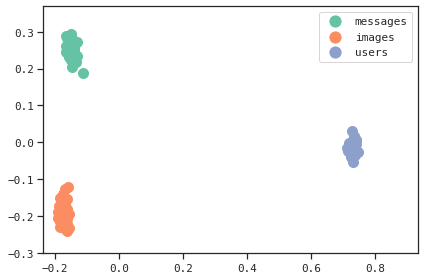

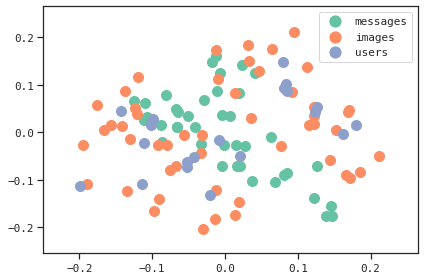

In [6]:
visualize_embeddings()
for df in [messages, images, users]:
    center_embeddings(df)
visualize_embeddings()

## Compute recommendations

In [7]:
prefs = get_prefs(pref='dot', temp=.01, k=3)

User 0
Demographics: 23 year old white female
Likes: active, outdoors, learning
Dislikes: mental, crafts, homemaking

#6/#5 (41%): female, young, adult, and smiling while leaning on the edge of a pool
Dive into the pool and feel the freedom! Swap screens for a refreshing swim, unleash your energy, and let the water ignite your senses.

#48/#6 ( 9%): female, young, adult, and white, and they are lifting a barbell
Why not give your thumbs a break and start pumping some iron? Weightlifting will boost your strength, tone your muscles, and leave you feeling unstoppable!

#33/#1 ( 6%): young, white, male, backpack, hiking, mountain, forest, view
Ditch the screen, hit the trail! Discover nature's wonders, boost your mood, and energize your body with an invigorating hike.


User 1
Demographics: 42 year old black male
Likes: outdoors, mental, active
Dislikes: learning, exploration, arts

#22/#9 (87%): male, adult, black, golfing, teeing off
Step away from the screen and tee off into a world of 